In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from pattern.en import tag
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
import en_core_web_sm
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praveen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Unzip and extract dataset
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
raw_df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
raw_df.shape

(278677, 9)

In [36]:
#Filtering to reduce local machine load
pro_filt = ['B005LERHD8','B005GYGD7O','B008WYDP1C','B0058XIMMM','B00CKGB85I','B007RD9DS8','B002RADHJC',
            'B000T9VK56','B0000C321X','B007WNWEFC','B0001ZNZJM','B007WA3K4Y','B007NLX16O','B00012O12A',
            'B0008EOEPK','B0007YR8WW','B0067GUM2W','B000O32MLI','B001IB70JY','B004Q7AB4I','B006PGGJOE',
            'B003NX87U6','B002PHLVJA','B008KK0ZJ8','B0083S18LQ','B005UVM368','B0007YVP1W','B00DNQIIE8',
            'B000KEG4V0','B004YM2FV2','B008NCYALM','B003XDVUEQ','B0007CKMA4','B008X0EW44','B00DMWQOYY',
            'B0078FXHNM','B000XDDERK','B002KMI7OC','B000J6ZYL0','B001Q5QLP6','B0074T7TY0','B00550PLV8',
            'B003DNR2HK','B007WAU1VY','B0008172S4','B00CIBCJ62','B0068VM5T4','B000FBO0DM','B000QW6LE6',
            'B000GOVRDE','B005CSNTJY','B0002TOZ1E','B004R1II48','B000DZUGOM','B00D1MR8YU','B00CN47GXA',
            'B001HEF6W0','B000PH25X8','B0013KDS96','B0000ANHST','B00DQYNS3I','B008RUOCJU','B007WAEBPQ',
            'B0053XF2U2','B0051U15E4','B001AOZVSQ','B0009F0Z38','B0026P45QW','B0007YXTOS','B0006LMBJ6',
            'B00BNB3A0W','B000EIJG0I','B000072UMJ','B000KKTPD8','B000FH4JJQ','B0076R6KY0','B0012QM8IS',
            'B0081IZ3UA','B0031U0PO2','B001188FZC','B00DMWQK0W','B004Z1CZDK','B009DNWFD0','B004M6XUI2',
            'B009ZDEXQK','B006SCSOOS','B0051D7GF8','B003DNR4XC','B002APTA9K','B0007QCOTM','B0009B3IN6',
            'B003YBHF82','B0012M0XSE','B000MXIMHI','B000KD44G8','B007DLVLAW','B0011D2FL2','B000KGOHLM',
            'B000EX15NY','B0019MPRJW']
df = raw_df[raw_df.asin.isin(pro_filt)]
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
340,A2S7YBFPZX1IGQ,B000072UMJ,alysha davis,"[0, 0]",fits true to size i can wear this with anything since it being a darker shade of purple wont stand out as much but still has that color its great just what i was looking for totally would recommen...,5.0,great shoes!,1362268800,"03 3, 2013"
341,AWF47TNS4EM6A,B000072UMJ,amazon_mama0312,"[0, 0]",I got these as a gift for my little sister. She had been wanting a pair of these for a really long time. I was so happy to find them here on amazon for the cheapest price ;) She absolutely LOVES t...,5.0,She loved them!!!,1398729600,"04 29, 2014"
342,A1UMN556PVE5ZJ,B000072UMJ,Angie,"[0, 0]",My daughter loves converse so the fact that it fit her witout us having to return or try on in the store was a plus - it arrived on time,5.0,Fit her well,1361232000,"02 19, 2013"


In [64]:
df.shape

(14153, 9)

In [65]:
# #Code Testing data to be hard coded

# row_data = []
# row_data.append([
#                     "This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++",
#                     "Great tutu-  not cheaply made"])

# row_data.append([
#                     "Great tutu for a great price. It isn't a &#34;full&#34; or high quality skirt, but it is perfect for my daughter to wear over leggings for her little outfits.",
#                     "Great value"])
# row_data.append(
#     ["My daughter liked this, and it with her costume, but she would have liked it to be a bit fuller.", 'Good'])
# row_data.append([
#                     "For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!",
#                     "WOW !! ..is al345l I have to say!"])
# row_data.append([
#                     "Wonder my niece wears it every single day, yellow is her favorite color right now an this cute little tutu made he da. It is well built and we hope she gets lots of wear out of it.",
#                     "Wonderful and great shipping."])
# row_data.append([
#                     "My daughter has worn this skirt almost every day since she received it and it's even been through the washer along with the other clothes.  It's amazing quality!  She fits a 4T and it's just above her knee, and has a little bit of growing room, although I'm not so sure as much as others are saying.  But considering how often she wears it, I'm not worried! ;)",
#                     'Excellent quality!'])

# df = pd.DataFrame(row_data, columns=['reviewText','summary'])

# # #preview dataframe
# # headers = review_df.dtypes.index
# # print(headers)
# # sample = review_df.head()
# # print(sample)

In [66]:
# df.head()

In [37]:
#Word Frequency bar chart
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

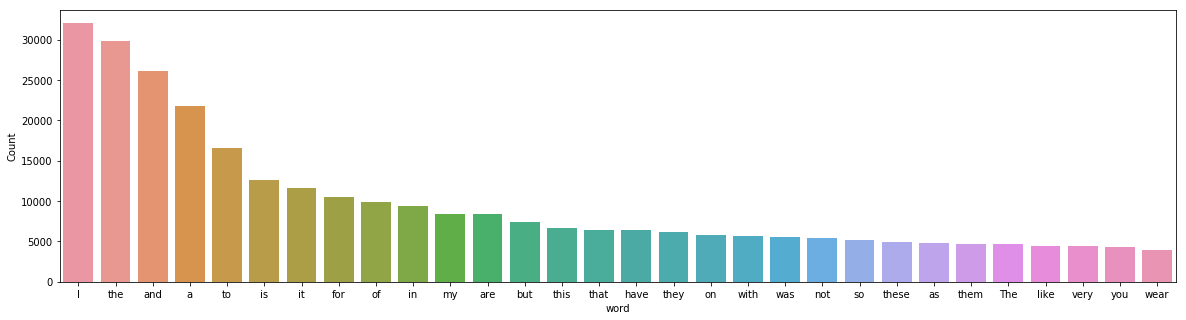

In [38]:
freq_words(df['reviewText'])

In [50]:
# replace "n't" with " not"
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

#number of stop words
stop = stopwords.words('english')
custom_stop = ['the','they','this']
for x in custom_stop:
    stop.append(x)
df['review_stopwords'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['summary_stopwords'] = df['summary'].apply(lambda x: len([x for x in x.split() if x in stop]))
print(df[['review_stopwords','summary_stopwords']].head(5))

#remove Stop words
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['summary'] = df['summary'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#convert all char to lower case
reviews = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['summary'] = df['summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))

     review_stopwords  summary_stopwords
340                 0                  0
341                 0                  1
342                 0                  0
343                 0                  0
344                 0                  0


In [33]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

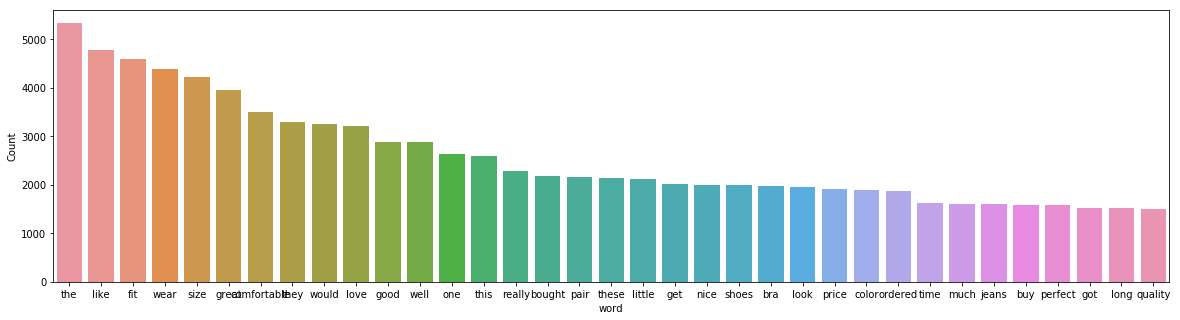

In [51]:
freq_words(reviews, 35)

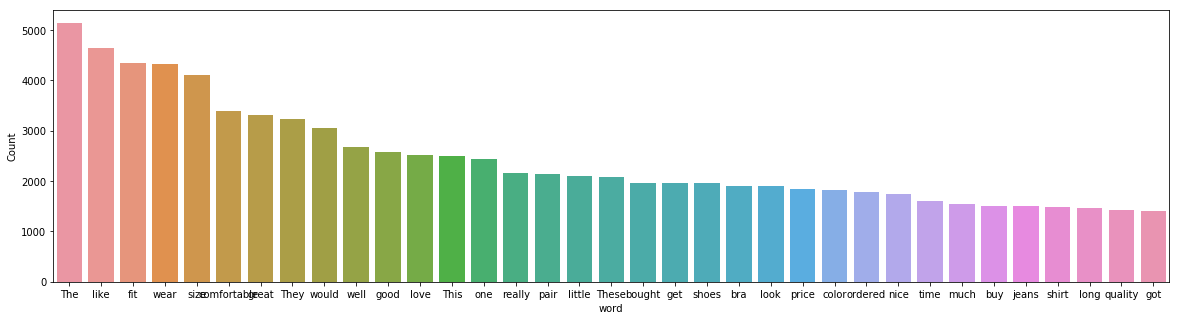

In [14]:
custom_stop = ['the','they','this']

df['review_stopwords'] = reviews.apply(lambda x: len([x for x in x.split() if x in custom_stop]))
df['review_stopwords'].head()
#remove Stop words
reviews = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in custom_stop))
freq_words(reviews, 35)

In [62]:
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#lemmatization method
def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

#tokenization
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews.iloc[[10]])

350    [old, son, needed, black, shoes, play, want, buy, dress, shoes, would, get, additional, wear, opted, black, converse, they, adorable, fit, well, size, little, kids, ordered, fine, bit, growing, ro...
Name: reviewText, dtype: object


In [63]:
#lemmatization takes a lot of time to load
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[10])

['old', 'son', 'need', 'black', 'shoe', 'play', 'want', 'buy', 'dress', 'shoe', 'would', 'get', 'additional', 'wear', 'opted', 'black', 'converse', 'adorable', 'fit', 'size', 'little', 'kid', 'order', 'fine', 'bit', 'grow', 'room', 'call', 'chuck', 'think', 'cool', 'wear', 'wear', 'several', 'time', 'play', 'overall', 'good', 'purchase']


In [65]:
# Merge processed reviews with df in a seperate column
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

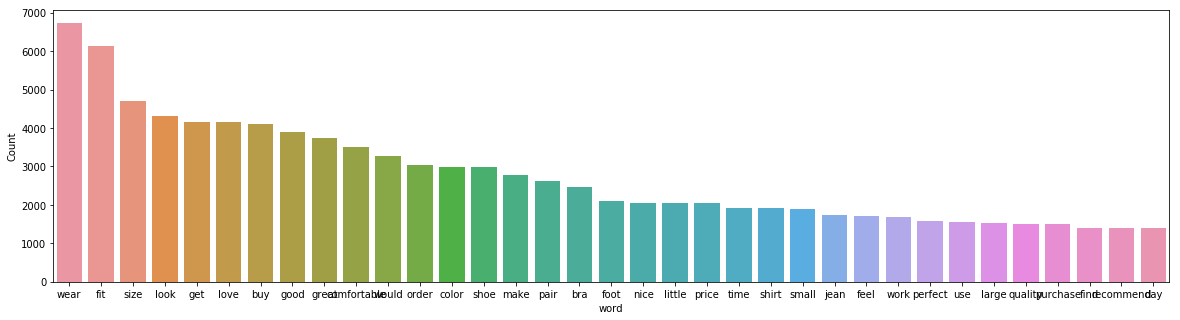

In [66]:
freq_words(df['reviews'], 35)

In [68]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [69]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
warnings.filterwarnings("ignore", category=DeprecationWarning)
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=5, 
                random_state=30,
                chunksize=1000,
                passes=1)
#Print topics
lda_model.print_topics(num_topics=5,num_words=5)

[(0,
  '0.041*"cute" + 0.031*"love" + 0.028*"look" + 0.028*"great" + 0.027*"wear"'),
 (1,
  '0.026*"necklace" + 0.022*"get" + 0.015*"buy" + 0.014*"love" + 0.014*"gift"'),
 (2,
  '0.026*"fit" + 0.023*"shirt" + 0.019*"look" + 0.012*"wear" + 0.012*"good"'),
 (3,
  '0.040*"foot" + 0.037*"shoe" + 0.029*"flop" + 0.026*"flip" + 0.026*"wear"'),
 (4,
  '0.049*"size" + 0.034*"order" + 0.030*"fit" + 0.023*"wear" + 0.022*"would"')]

In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.037123  0.128099       1        1  24.769835
0     -0.010310 -0.012159       2        1  20.570139
4     -0.020395  0.075947       3        1  20.546127
3      0.200839 -0.057943       4        1  18.071260
1     -0.133012 -0.133944       5        1  16.042645, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
264   Default  2817.000000         cute  2817.000000  30.0000  30.0000
10    Default  3979.000000         size  3979.000000  29.0000  29.0000
158   Default  2854.000000         foot  2854.000000  28.0000  28.0000
3921  Default  1716.000000         flop  1716.000000  27.0000  27.0000
44    Default  3516.000000         shoe  3516.000000  26.0000  26.0000
4183  Default  1656.000000         flip  1656.000000  25.0000  25.0000
90    Default  3302.000000        order  3302.000000  24.0000  24.0000
8523  Default  1680.000000     necklace  1680.000000  23.0000  23.0000
2885  Default  1068.000000         yoga  1068.000000  22.0000  22.0000
47    Default  1163.000000         walk  1163.000000  21.0000  21.0000
637   Default  2746.000000        shirt  2746.000000  20.0000  20.0000
3117  Default   926.000000        strap   926.000000  19.0000  19.0000
239   Default  3547.000000  comfortable  3547.000000  18.0000  18.0000
22    Default   755.000000         gift   755.000000  17.0000  17.0000
59    Default  1715.000000        small  1715.000000  16.0000  16.0000
5     Default  3440.000000        great  3440.000000  15.0000  15.0000
4131  Default  1277.000000       sandal  1277.000000  14.0000  14.0000
4     Default  5281.000000          fit  5281.000000  13.0000  13.0000
56    Default  1290.000000        large  1290.000000  12.0000  12.0000
8911  Default   865.000000        chain   865.000000  11.0000  11.0000
8473  Default   794.000000      earring   794.000000  10.0000  10.0000
28    Default  1921.000000        price  1921.000000   9.0000   9.0000
168   Default   872.000000          toe   872.000000   8.0000   8.0000
26    Default  5033.000000         love  5033.000000   7.0000   7.0000
6     Default  5137.000000         look  5137.000000   6.0000   6.0000
166   Default   588.000000      support   588.000000   5.0000   5.0000
1801  Default  1062.000000      sweater  1062.000000   4.0000   4.0000
173   Default  1103.000000        comfy  1103.000000   3.0000   3.0000
1415  Default   684.000000        piece   684.000000   2.0000   2.0000
9086  Default   671.000000          owl   671.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
9086   Topic5   492.840729          owl   671.452087   1.5207  -4.6767
400    Topic5   337.605499        break   446.711548   1.5499  -5.0551
1678   Topic5    88.147926         wrap   101.440140   1.6895  -6.3979
1415   Topic5   452.627289        piece   684.180664   1.4168  -4.7619
602    Topic5   184.878326      package   245.654083   1.5457  -5.6572
1196   Topic5   151.782639        metal   195.920639   1.5747  -5.8545
149    Topic5   235.755997          fun   362.013733   1.4010  -5.4141
32     Topic5   336.851715       arrive   587.984741   1.2729  -5.0573
651    Topic5   323.064056          pay   575.175537   1.2531  -5.0991
1627   Topic5   167.907242         ring   239.067169   1.4766  -5.7535
214    Topic5   331.093384         item   618.857544   1.2044  -5.0745
1906   Topic5   255.476166    beautiful   439.335938   1.2878  -5.3338
212    Topic5   505.253387         give  1206.727295   0.9593  -4.6519
21     Topic5  1182.954224          get  4628.405762   0.4657  -3.8012
675    Topic5   278.678864      receive   522.283936   1.2018  -5.2469
27     Topic5   685.438721         pair  2271.691650   0.6317  -4.3469
226    Topic5   379.735321         take   898.659668   0.9685  -4.9375
155    Topic5   473.590912   

## Compute Model Perplexity and Coherence Score

In [90]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.980298403359398

Coherence Score:  0.46490571261402563


## Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    

In [91]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [92]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=40, step=6)

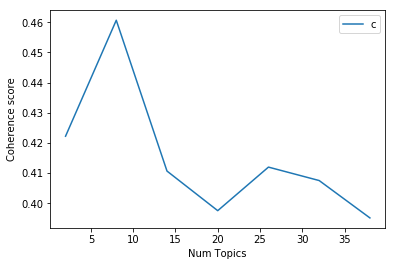

In [93]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [94]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4222
Num Topics = 8  has Coherence Value of 0.4606
Num Topics = 14  has Coherence Value of 0.4107
Num Topics = 20  has Coherence Value of 0.3976
Num Topics = 26  has Coherence Value of 0.412
Num Topics = 32  has Coherence Value of 0.4076
Num Topics = 38  has Coherence Value of 0.3952


In [95]:
print(model_list[3])


LdaModel(num_terms=9898, num_topics=20, decay=0.5, chunksize=2000)


In [96]:
# Select the model and print the topics
import pprint
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

## '''Finding the dominant topic in each sentence'''

In [97]:
def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=reviews_2):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix,texts=reviews_2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9484,"great, wear, foot, black, color, fit, would, look, good, buy","[fit, true, size, wear, anything, dark, shade, purple, will, stand, color, great, look, would, recommend, anyone]"
1,1,6.0,0.6940,"necklace, buy, get, price, love, good, look, earring, would, gift","[get, gift, little, sister, want, pair, long, time, happy, find, amazon, cheap, price, love, wear, day, great, deal]"
2,2,6.0,0.4109,"necklace, buy, get, price, love, good, look, earring, would, gift","[daughter, love, converse, fact, fit, witout, return, try, store, arrive, time]"
3,3,0.0,0.4455,"size, love, wear, comfortable, foot, fit, great, sandal, comfy, color","[love, shoe, true, form, fit, love, brightness, light, orange, color]"
4,4,0.0,0.9204,"size, love, wear, comfortable, foot, fit, great, sandal, comfy, color","[fit, feel, great, walk, recommend, shoe, anyone, great, shoe, summer]"
5,5,4.0,0.7844,"shoe, foot, wear, comfortable, size, get, strap, order, walk, would","[wife, love, shoe, size, convertion, little, biggie, send, get, right, size]"
6,6,7.0,0.4605,"fit, size, wear, order, small, shirt, would, large, get, material","[look, red, chuck, love, would, recommend, get, half, size, full, size, small, run, large]"
7,7,3.0,0.6045,"look, love, fit, color, wear, great, comfortable, shirt, good, size","[converse, make, long, kid, ask, love, pair, assort, color, nothing, complain, change, point]"
8,8,1.0,0.4859,"flop, cute, flip, wear, comfortable, pair, get, great, love, buy","[purchase, gift, daughter, wear, time, may, borrow]"
9,9,0.0,0.6085,"size, love, wear, comfortable, foot, fit, great, sandal, comfy, color","[buy, grown, daughter, love, fit, age, would, love]"


## Find the most representative document for each topic

In [98]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9649,"size, love, wear, comfortable, foot, fit, great, sandal, comfy, color","[want, pair, seem, everyone, pair, love, fit, small, size, wear, make, foot, look, huge, seem, slip, foot, wish, could, wear, reputation, easy, fit, style]"
1,1.0,0.9781,"flop, cute, flip, wear, comfortable, pair, get, great, love, buy","[buy, look, store, line, retailer, find, cheap, buy, material, different, example, leather, new, model, use, synthetic, material, make, shoe, lot, cheap, course, believe, get, pay, shoe, go, get, ..."
2,2.0,0.9865,"great, wear, foot, black, color, fit, would, look, good, buy","[order, black, white, sock, advertised, ratio, include, polyester, black, one, label, polyester, white, one, advertise, price, favorable, send, black, sock, feel, difference, polyester, make, woul..."
3,3.0,0.9809,"look, love, fit, color, wear, great, comfortable, shirt, good, size","[backpack, roomy, use, hold, case, zombie, apocalypse, emergency, supply, think, would, need, backpack, hold, everything, fit, bag, huge, main, zipper, compartment, several, small, one, compartmen..."
4,4.0,0.9846,"shoe, foot, wear, comfortable, size, get, strap, order, walk, would","[let, say, get, correct, size, bra, size, little, snug, torpedo, expect, chest, look, ice, cream, cone, stick, sure, playtex, think, go, find, gel, shoulder, pad, comfortable, scallop, edge, bra, ..."
